### Useful Resources

- [A Practical Guide to LambdaMART in LightGbm](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6)
- [lightgbm.LGBMRanker Documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html#)
- [LightGBM Parameter Tuning Guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [How To Use Optuna to Tune LightGBM Hyperparameters](https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/)
- [Optuna](https://optuna.readthedocs.io/en/stable/tutorial/index.html)

### Global Constants

In [1]:
# --------------- Model --------------- #
# k for NDCG@k
K = 5    
# Number of iterations/trees for LightGBM              
NUM_ITERATIONS = 300 # 1000

# --------------- Tuning --------------- #
# number of trials for Optuna
N_TRIALS = 50   # 30

### Libraries

In [2]:
import psutil
import os
from pathlib import Path
from datetime import datetime
import json

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import pickle

/Users/jeniamakarchik/opt/anaconda3/envs/dmt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from data import read_processed_train, read_processed_val, read_processed_test

### Read Data

In [5]:
train_df = read_processed_train()
val_df = read_processed_val()
test_df = read_processed_test()

In [6]:
train_df.shape, val_df.shape, test_df.shape

((3966355, 35), (991992, 35), (4959183, 31))

### Change Target

**Function Definitions**
- Take in train_df or val_df and modify the target column
- All columns can be used
- Do not change the row order
- **target must be an integer**

In [7]:
def base_target(df):
    """
    Applies the weighting given in the assignment (no discounting)
    """
    df['target'] = 0

    mask = df['click_bool'] == 1
    df.loc[mask, 'target'] = 1

    mask = df['booking_bool'] == 1
    df.loc[mask, 'target'] = 5

    return df

<Axes: >

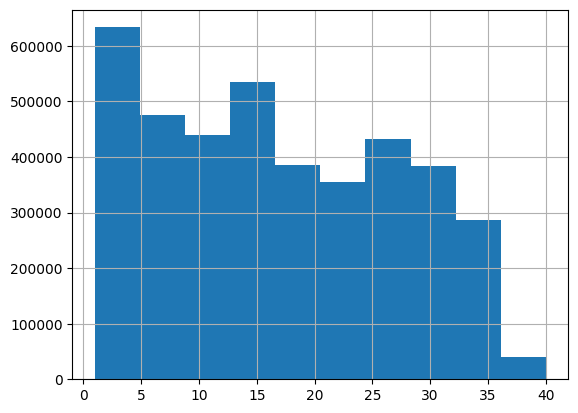

In [8]:
train_df.position.hist()

<Axes: >

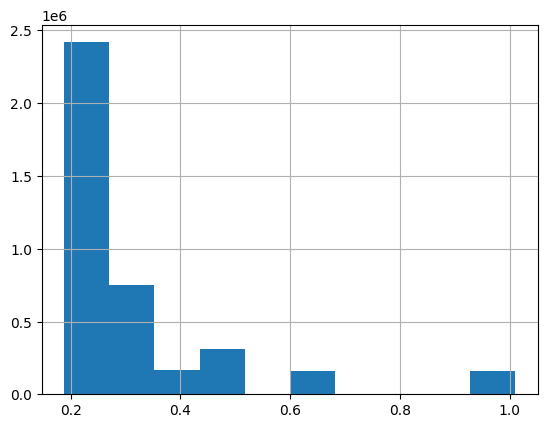

In [9]:
(0.7/np.log(train_df.position + 1)).hist()

In [10]:
def target_position_bias(df, alpha=0.5):
    """
    Apply positional bias on base target.

    Args:
        df (_type_): dataframe
        alpha (float, optional): Scaling paramaeter for the positional bias. Bigger values makes the interval of ranks wider. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    
    df['target'] = 0.
    df.loc[df['click_bool'] == 1, 'target'] = 1.
    df.loc[df['booking_bool'] == 1, 'target'] = 5.

    # mask = df.random_bool == 0 # non random order
    # df.loc[mask, 'target'] = df.loc[mask, 'target'] * alpha / np.log(df.loc[mask, 'position'] + 1)

    # mask = (df.random_bool == 1) & (df.click_bool == 1) & (df.booking_bool == 0) # random and clicks
    # df.loc[mask, 'target'] = df.loc[mask, 'target'] * alpha / np.log(df.loc[mask, 'position'] + 1)

    # df['target'] = np.clip(np.ceil(train_df.target), 0, 20) # rounds to the integer from right

    return df


In [11]:
# Add others...

**Apply Functions**

- Apply one of the above functions to train_df and val_df

In [12]:
# Choice of target function
# target_func = target_position_bias
target_func = base_target

# ---------------------------------- #

# Apply target function
train_df = target_func(train_df)
val_df = target_func(val_df)

<Axes: >

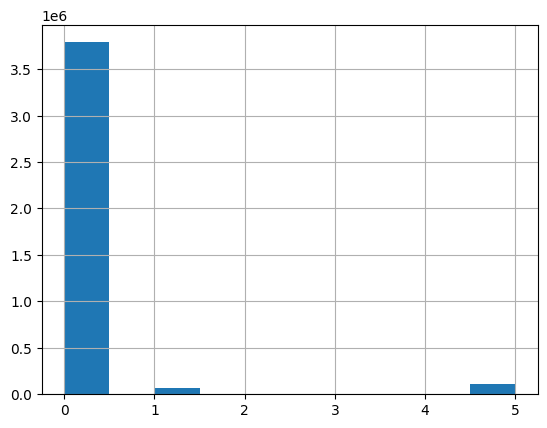

In [13]:
train_df.target.hist()

In [14]:
train_df['target'].unique()

array([0, 5, 1])

### Feature Engineering

**Function Defintions**
- Take in a dataframe and modify/add columns
- Must be applicable to train_df, val_df and test_df
- Do not change the row order

In [15]:
def hour_day_month_year(df):
    """
    Function to create day, month, year columns from date_time column.
    """
    df['date_time'] = pd.to_datetime(df['date_time'])

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year
    df['weekday'] = df['date_time'].dt.weekday

    return df

In [16]:
def log_price(df):
    """
    Function to have logarithm of the price since it can be per day or per stay.
    """
    df['log_price_usd'] = np.log(df['price_usd'] + 1)
    return df

In [17]:
def diff_hist_log_price_and_price(df):
    """
    Function to create var with diff btw current price and historical.
    """
    df['diff_log_price'] = np.log(df['price_usd'] + 1) - df['prop_log_historical_price']

    return df

In [18]:
# Add others...

**Apply Functions**

- Apply some combination of the above functions to train_df, val_df and test_df

Functions that should take values from train set and apply on val and test sets.

In [19]:
# List of functions to apply in order
feature_functions = [
    hour_day_month_year,
    log_price,
    diff_hist_log_price_and_price
]

# ---------------------------------- #

# Apply listed functions
for func in feature_functions:
    train_df = func(train_df)
    val_df = func(val_df)
    test_df = func(test_df)

In [20]:
by_cols_norm = [
    'srch_id',
    'srch_destination_id',
    # 'srch_booking_window',
    'prop_id',
    'prop_country_id',
    # 'month',
    'site_id'
]

In [21]:
cols = [
    # 'price_usd',
    'log_price_usd',
    'prop_review_score',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price'
]

In [22]:
def normalise_by_cols(train_df, val_df, test_df, by_cols, columns):
    def fit(df, by_col, columns):
        print(f'Fitting means ans stds... - {by_col}')
        all_columns = [by_col] + columns
        groups = train_df[all_columns].groupby(by_col)

        means = groups.mean()
        stds = groups.std()

        return dict(zip(means.index, means.values)), dict(zip(stds.index, stds.values))
    
    def transform(df, by_col, columns):
        print('Transformong columns...')
        for idx, col in enumerate(columns):
            print(col)
            upd_colname = f'norm_{col}_{by_col}'

            df[upd_colname] = df[by_col].map(lambda x: -means[x][idx]  if x in means else 0)
            df[upd_colname] = df[upd_colname] + df[col]
            df[upd_colname] = df[upd_colname] / df[by_col].map(lambda x: -stds[x][idx] if x in stds else 1)

        print('---')
        return df

    for by_col in by_cols:
        means, stds = fit(train_df, by_col, columns)

        train_df = transform(train_df, by_col, columns)
        val_df = transform(val_df, by_col, columns)
        test_df = transform(test_df, by_col, columns)
    
    return train_df, val_df, test_df

In [23]:
train_df, val_df, test_df = normalise_by_cols(train_df, val_df, test_df, by_cols_norm, cols)

Fitting means ans stds... - srch_id
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Fitting means ans stds... - srch_destination_id
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Transformong columns...
price_usd
log_price_usd
prop_review_score
prop_location_score1
prop_location_score2
prop_log_historical_price
---
Fitting means ans stds... - srch_booking_window
Transformong columns...
price_usd
log_pr

### Final Data Preparation

Removing unwanted columns and preparing the data for the model

In [25]:
# Specify additional columns to remove
new_drop_cols = ['price_usd']
add_drop_cols = ['srch_id', 'date_time', 'prop_id'] + new_drop_cols

# ---------------------------------- #

# Remove columns that won't be used as features
train_only_cols = ['position', 'click_bool', 'booking_bool', 'target'] + add_drop_cols

# Train data
group_train = train_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_train = train_df.drop(columns=train_only_cols)
y_train = train_df['target'].astype(int)

print(X_train.columns)
print(len(X_train.columns))

# Validation data
group_val = val_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_val = val_df.drop(columns=train_only_cols)
y_val = val_df['target'].astype(int)

# Test data
X_test = test_df.copy()
X_test = X_test.drop(columns=add_drop_cols)
print(len(X_test.columns))
print(set(X_test) - set(X_train))
X_test = X_test.to_numpy(copy=True)

Index(['site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'orig_destination_distance', 'random_bool', 'comp2_rate', 'comp2_inv',
       'comp3_rate', 'comp3_inv', 'comp5_rate', 'comp5_inv', 'comp8_rate',
       'comp8_inv', 'hour', 'day', 'month', 'year', 'weekday', 'log_price_usd',
       'diff_log_price', 'norm_price_usd_srch_id',
       'norm_log_price_usd_srch_id', 'norm_prop_review_score_srch_id',
       'norm_prop_location_score1_srch_id',
       'norm_prop_location_score2_srch_id',
       'norm_prop_log_historical_price_srch_id',
       'norm_price_usd_srch_destination_id',
       'norm_log_price_usd_srch_destination_id

### Tuning

In [32]:
# Create the folder to store the results of the tuning
tune_folder_path = Path("./tuned_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
tune_folder_path.mkdir(parents=True, exist_ok=True)

Constant hyperparameters

In [33]:
print(f'Gain labels: {[i for i in range(max(y_train.max(), y_val.max()) + 1)]}')

Gain labels: [0, 1, 2, 3, 4, 5]


In [34]:
const_params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "ndcg",
    "n_estimators": NUM_ITERATIONS,
    'max_depth': -1,
    "importance_type": "gain",
    "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
    "bagging_freq": 1,
    "n_jobs": psutil.cpu_count(logical=False) - 1,
    "verbosity": -1,
    # new params
    "early_stopping_round": int(NUM_ITERATIONS/10),  # stops if 10% of iterations val score doesn't improve
    # fixed params
    # "num_leaves": 35
    }

Define the objective

- num_leaves: [20, 35]
- learning_rate: [0.001, 0.01]
- min_data_in_leaf: [100, 5000]
- min_gain_to_split: [0.01, 1]
- bagging_fraction: [0.5, 0.9] - number of oservations to use for learning
- feature_fraction: [0.01, 0.5] - number of features to use for learning
- bagging_freq: [1, 5] - every bagging_freq iterations data is resampled


In [35]:
def objective(trial):
    tuned_params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 40),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 1500),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.01, 1, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.7),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
    }

    params = const_params | tuned_params

    model = lgb.LGBMRanker(**params)
    model.fit(
        X=X_train,
        y=y_train,
        group=group_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        eval_group=[group_train, group_val],
        eval_at=[K], # k for NDCG@k
        verbose=False,
      )
    
    # Save the trained model
    with open(tune_folder_path / f"trial_{trial.number}.pkl", "wb") as f:
        pickle.dump(model, f)

    best_val_score = model.best_score_['valid_1'][f'ndcg@{K}']
    return best_val_score

Optimise the objective

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2023-05-27 14:36:06,828] A new study created in memory with name: no-name-ed7f50f5-d39e-4947-b4e2-367c46f16d20
/Users/jeniamakarchik/opt/anaconda3/envs/dmt/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-27 14:37:22,676] Trial 0 finished with value: 0.36458124984025697 and parameters: {'num_leaves': 22, 'learning_rate': 0.0036954789129182244, 'min_data_in_leaf': 590, 'min_gain_to_split': 0.3275262695209651, 'bagging_fraction': 0.5530858212769136, 'feature_fraction': 0.6038802650704016, 'bagging_freq': 1}. Best is trial 0 with value: 0.36458124984025697.
/Users/jeniamakarchik/opt/anaconda3/envs/dmt/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and wil

Save the results

In [37]:
# Keep only the best model (and rename it)
for trial in study.trials:
    if trial.number != study.best_trial.number:
        os.remove(tune_folder_path / f"trial_{trial.number}.pkl")
    else:
        os.rename(tune_folder_path / f"trial_{trial.number}.pkl", tune_folder_path / "best_model.pkl")

In [38]:
# Save the best hyperparameters
with open(tune_folder_path / "best_params.json", "w") as f:
    best_params = const_params | study.best_params
    json.dump(best_params, f)

# Save some other relevant information
with open(tune_folder_path / "info.txt", "w") as f:
    f.write(f"{10 * '-'} Global constants {10 * '-'}\n\n")
    f.write(f"NUM_ITERATIONS = {NUM_ITERATIONS}\n")
    f.write(f"K = {K}\n")
    f.write(f"N_TRIALS = {N_TRIALS}\n\n")
    f.write(f"{10 * '-'} Features {10 * '-'}\n\n")
    f.write(f"{list(X_train.columns)}\n\n")
    f.write(f"{10 * '-'} Study Info {10 * '-'}\n\n")
    f.write(f"Best value: {study.best_value}\n")
    f.write(f"Best trial number: {study.best_trial.number}\n")

In [ ]:
# Add plots

### Training

**Load the model (choose one)**

1. Create a new model with hand-picked hyperparameters

In [ ]:
params = {
        # Constant parameters
        "objective": "lambdarank",
        "boosting_type": "gbdt",
        "metric": "ndcg",
        "n_estimators": NUM_ITERATIONS, 
        "importance_type": "gain",
        "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
        # "bagging_freq": 1,
        "n_jobs": 2,
        "verbosity": 1,
        # Tuning parameters
        "num_leaves": 32,
        # 'max_depth': 1,
        "learning_rate": 0.01,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_data_in_leaf": 50,
    }

model = lgb.LGBMRanker(**params)

In [26]:
params = {
	"objective": "lambdarank",
	"boosting_type": "gbdt",
	"metric": "ndcg",
	"n_estimators": 2000,
	"max_depth": -1,
	"importance_type": "gain",
	"label_gain": [
		0,
		1,
		2,
		3,
		4,
		5
	],
	"bagging_freq": 4,
	"n_jobs": 3,
	"verbosity": -1,
	"early_stopping_round": 200,
	"num_leaves": 32,
	"learning_rate": 0.008,
	"min_data_in_leaf": 750,
	"min_gain_to_split": 0.2,
	"bagging_fraction": 0.6,
	"feature_fraction": 0.4
}



model = lgb.LGBMRanker(**params)


2. Create a new model with the most recently tuned hyperparamters

In [ ]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]

with open(root / most_recent_dir / "best_params.json", "r") as f:
    best_params = json.load(f)

best_params["n_estimators"] = 2000
best_params["early_stopping_round"] = 100

model = lgb.LGBMRanker(**best_params)
print(model)

3. Load the best model from the most recent tuning process

In [ ]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]
model_path = root / most_recent_dir / "best_model.pkl"

model = pickle.load(open(model_path, "rb"))

4. Custom

In [ ]:
# Create a lgb.LGBMRanker model however you like
# model = ...

**Fitting the model** (skip if using a trained model)

In [49]:
print(model)

LGBMRanker(bagging_fraction=0.6, bagging_freq=4, early_stopping_round=200,
           feature_fraction=0.4, importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5], learning_rate=0.008, metric='ndcg',
           min_data_in_leaf=750, min_gain_to_split=0.2, n_estimators=2000,
           n_jobs=3, num_leaves=32, objective='lambdarank', verbosity=-1)


In [27]:
print(datetime.now())

model.fit(
      X=X_train,
      y=y_train,
      group=group_train,
      eval_set=[(X_train, y_train),(X_val, y_val)],
      eval_group=[group_train, group_val],
      eval_at=[K] # k for NDCG@k
      )

2023-05-27 18:34:20.788216
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[1]	training's ndcg@5: 0.310324	valid_1's ndcg@5: 0.158677
[2]	training's ndcg@5: 0.329369	valid_1's ndcg@5: 0.23038
[3]	training's ndcg@5: 0.341534	valid_1's ndcg@5: 0.268992
[4]	training's ndcg@5: 0.352233	valid_1's ndcg@5: 0.293653
[5]	training's ndcg@5: 0.357545	valid_1's ndcg@5: 0.315072
[6]	training's ndcg@5: 0.358869	valid_1's ndcg@5: 0.325366
[7]	training's ndcg@5: 

LGBMRanker(bagging_fraction=0.6, bagging_freq=4, early_stopping_round=200,
           feature_fraction=0.4, importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5], learning_rate=0.008, metric='ndcg',
           min_data_in_leaf=750, min_gain_to_split=0.2, n_estimators=2000,
           n_jobs=3, num_leaves=32, objective='lambdarank', verbosity=-1)

### Plots

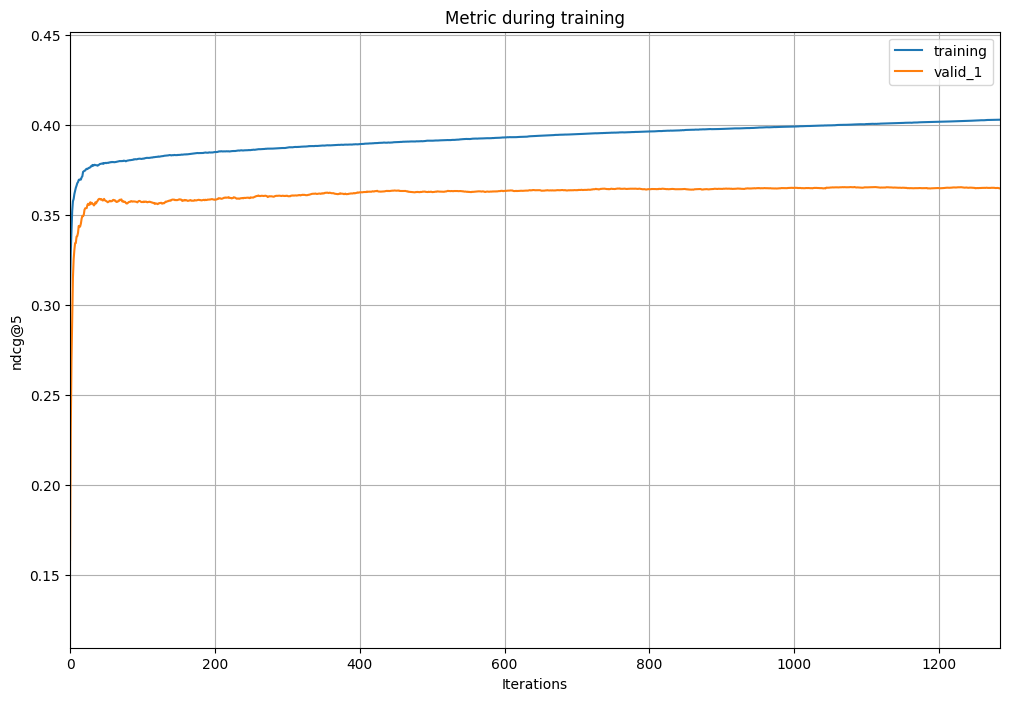

In [28]:
ax_metric = lgb.plot_metric(model, figsize = (12,8))

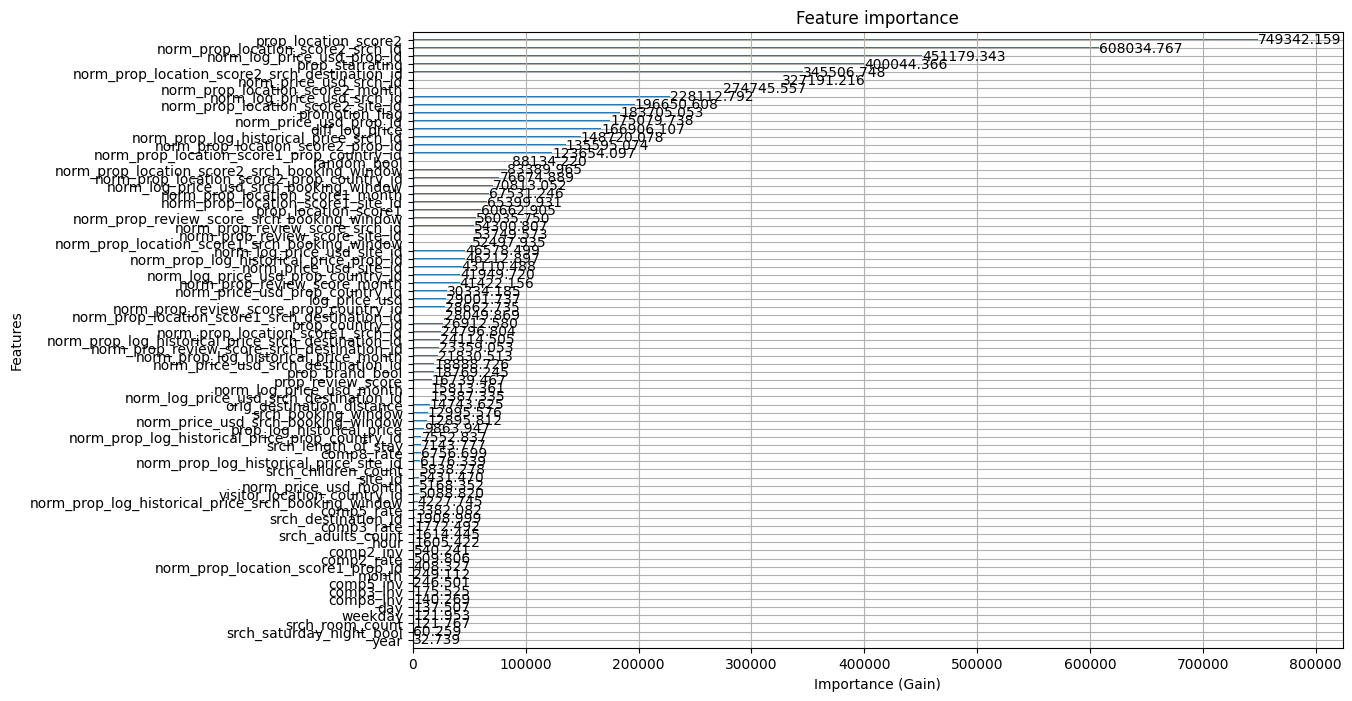

In [29]:
ax_importance = lgb.plot_importance(model, xlabel='Importance (Gain)', figsize = (12,8))

### Testing

In [36]:
prediction = model.predict(X_test)
prediction

array([ 0.00973586,  0.07464241,  0.02404711, ..., -0.7389103 ,
        0.10523567,  0.24275072])

In [37]:
solution = test_df[['srch_id', 'prop_id']].copy()
solution['prediction'] = prediction
solution.head()

,srch_id,prop_id,prediction
0,1,3180,0.009736
1,1,5543,0.074642
2,1,14142,0.024047
3,1,22393,-0.206699
4,1,24194,1.325978


In [38]:
solution.sort_values(by=['srch_id', 'prediction'], ascending=[True, False])

,srch_id,prop_id,prediction
23,1,99484,1.746061
12,1,61934,1.572264
9,1,54937,1.398887
4,1,24194,1.325978
5,1,28181,1.125097
...,...,...,...
4959179,332787,33959,0.329826
4959182,332787,99509,0.242751
4959181,332787,94437,0.105236
4959178,332787,32019,0.091371


### Save Results

In [39]:
# Create the folder to store the results of the training
train_folder_path = Path("./trained_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
train_folder_path.mkdir(parents=True, exist_ok=True)

# Save the model
pickle.dump(model, open(train_folder_path / "model.pkl", "wb"))

# Save the parameters
with open(train_folder_path / "params.txt", "w") as f:
    f.write(json.dumps(model.get_params()))

# Save the feature names
with open(train_folder_path / "feature_names.txt", "w") as f:
    f.write(str(list(X_train.columns)))

# Save the figures
ax_metric.figure.savefig(train_folder_path / "learning_curve.pdf", bbox_inches="tight")
ax_importance.figure.savefig(train_folder_path / "feature_importance.pdf", bbox_inches="tight")

# Save best evaluation scores
with open(train_folder_path / "best_scores.txt", "w") as f:
    f.write("Best training score: " + str(model.best_score_['training'][f'ndcg@{K}']) + "\n")
    f.write("Best validation score: " + str(model.best_score_['valid_1'][f'ndcg@{K}']) + "\n")

# Save the submission file
submission_file = train_folder_path / "submission.csv"
test_df[['srch_id', 'prop_id']].to_csv(submission_file, index=False)

### Playground

In [ ]:
x = {"a": 1, "b": 2}
y = {"c": 3, "d": 4}

x | y